In [2]:
# 5G Traffic Prediction Using LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta

# Load data
file_path = "/content/synthetic_5g_traffic_6_months.csv"
df = pd.read_csv(file_path)

# Preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
data = df[['total_traffic']]

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences (e.g., 24-hour window)
def create_sequences(data, window_size):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(x), np.array(y)

window_size = 24
x, y = create_sequences(data_scaled, window_size)

# Train-test split (e.g., 80% train, 20% test)
split = int(len(x) * 0.8)
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=32,
                    validation_data=(x_test, y_test), callbacks=[es])

# Predict on test data
y_pred = model.predict(x_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Compute R^2 Score
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"\nR^2 Score on Test Data: {r2:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0781 - val_loss: 0.0326
Epoch 2/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0287 - val_loss: 0.0173
Epoch 3/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0182 - val_loss: 0.0161
Epoch 4/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150 - val_loss: 0.0128
Epoch 5/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 6/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 7/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0122 - val_loss: 0.0107
Epoch 8/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112 - val_loss: 0.0104
Epoch 9/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 10/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100 - val_loss: 0.0103
Epoch 11/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 12/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

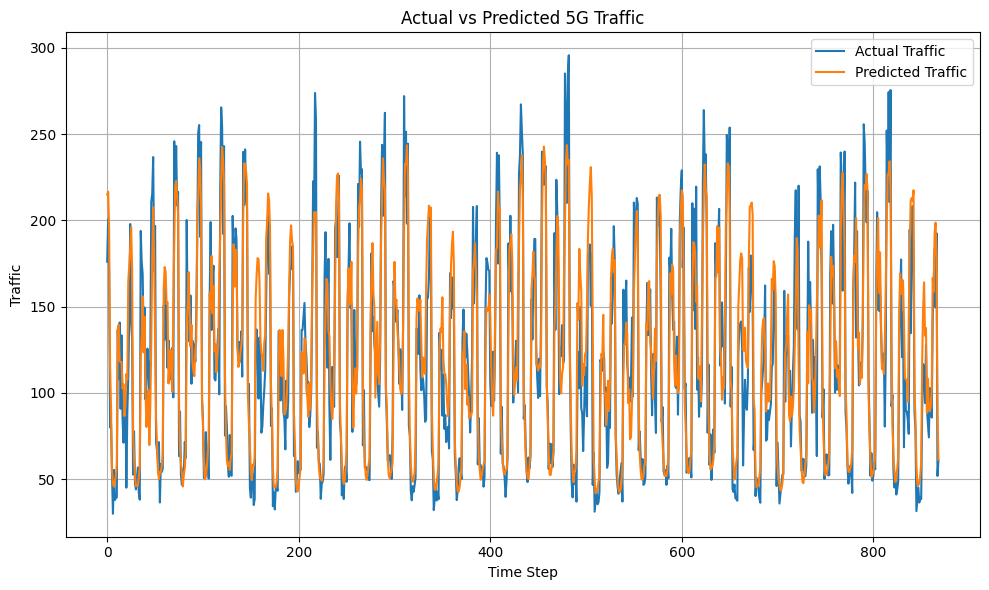

In [3]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual Traffic')
plt.plot(y_pred_inv, label='Predicted Traffic')
plt.legend()
plt.title('Actual vs Predicted 5G Traffic')
plt.xlabel('Time Step')
plt.ylabel('Traffic')
plt.grid()
plt.tight_layout()
plt.show()


In [5]:
# Future prediction (e.g., next 48 hours)
last_window = data_scaled[-window_size:]
future_predictions = []
current_input = last_window.copy()

for _ in range(48):  # Predict next 48 hours
    pred = model.predict(current_input.reshape(1, window_size, 1))
    future_predictions.append(pred[0][0])
    current_input = np.append(current_input[1:], pred, axis=0)

# Inverse transform and create timestamps
future_traffic = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
last_timestamp = df.index[-1]
future_dates = [last_timestamp + timedelta(hours=i+1) for i in range(48)]

# Create a future DataFrame
future_df = pd.DataFrame({
    'timestamp': future_dates,
    'predicted_traffic': future_traffic.flatten()
})

print("\nFuture 48-Hour Traffic Predictions:")
print(future_df)


# Save future predictions
future_df.to_csv("future_5g_traffic_predictions.csv", index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━